# _0_. MyUtils Package

## ComFeatureSet.py


In [8]:
import numpy as np

# Supervised Learning을 위한 class를 부여한다
# 종목마다 변동성이 다르므로 목표 수익률을 "변동성의 몇 배"로 정의한다.
# ex : up = 0.5 이면 변동성의 +0.5 배.
# up : 목표 수익률 표준편차 배수
# dn : 손절률 표준편차 배수
# period : holding 기간
# return : 0 - 주가 횡보, 1 - 주가 하락, 2 - 주가 상승
# --------------------------------------------------------------
def getUpDnClass(data, up=1, dn=-1, period=20):
    # 주가 수익률의 표준편차를 측정한다. 컬럼 이름은 class라고 부여해 놓는다.
    # 수익률 표준편차 (변동성)는 목표 수익률과 손절률을 계산하기 위해 임시로 사용된다.
    data['class'] = np.log(data['close']) - np.log(data['close'].shift(1))
    s = np.std(data['class'])

    # 목표 수익률과 손절률을 계산한다
    uLimit = up * s * np.sqrt(period)
    dLimit = dn * s * np.sqrt(period)
    
    # 가상 Trading을 통해 미래 주가 방향에 대한 Class를 결정한다. class에는 원래 수익률이 기록되어 있었으나 NaN을 기록해 둔다
    data['class'] = np.nan
    for i in range(len(data)-period):
        buyPrc = data.iloc[i].close     # 매수 포지션을 취한다
        y = np.nan
            
        # 매수 포지션 이후 청산 지점을 결정한다
        duration = 0    # 보유 기간
        for k in range(i+1, len(data)):
            sellPrc = data.iloc[k].close
            #rtn = np.log(sellPrc / buyPrc)  # 수익률을 계산한다
            rtn = (sellPrc - buyPrc) / buyPrc
            
            # 목표 수익률이나 손절률에 도달하면 루프를 종료한다
            if duration > period:
                y = 0           # hoding 기간 동안 목표 수익률이나 손절률에 도달하지 못했음. 주가가 횡보한 것임.
                break
            else:
                if rtn > uLimit:
                    y = 2       # 수익
                    break
                elif rtn < dLimit:
                    y = 1       # 손실
                    break
            duration += 1
        data.iloc[i, 5] = y     # class 컬럼에 y를 기록한다.
    data = data.dropna()    # 마지막 부분은 class를 결정하지 못해 NaN이 기록되어 있으므로 이를 제거한다.
    return data

In [ ]:
# def getUpDnClass(data, up=1, dn=-1, period=20):
#     data['class'] = np.log(data['close']) - np.log(data['close'].shift(1)) # close 누적 해체
#     s = np.std(data['class']) # 변동성 : 수익률 표준편차

#     u_limit = up*s*np.sqrt(period)
#     d_limit = dn*s*np.sqrt(period)

#     # 미래 주가방향에 대한 class 결정
#     data['class'] = np.nan # NaN 기록
#     for i in range(len(data)-period):
#         buy_prc = data.iloc[i]['close'] # 매수 포지션
#         y = np.nan

#         # 청산지점 결정
#         duration = 0 # 보유 기간
#         for k in range(i+1, len(data))

## MyTimeSeries.py

In [9]:
# 시계열분석 관련 함수를 정의한다
#
# 한국생산성본부 금융 빅데이터 전문가 과정 (금융 모델링 파트) 실습용 코드
# Written : 2018.2.5
# 제작 : 조성현
# -----------------------------------------------------------------
import numpy as np
import scipy.stats as stats
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# ARIMA(ar, d, ma) 모형으로 n개의 데이터를 샘플링한다
def sampleARIMA(ar, d, ma, n):
    arparams = np.array(ar)
    maparams = np.array(ma)
    ar = np.r_[1.0, -arparams] # add zero-lag and negate
    ma = np.r_[1.0, maparams]  # add zero-lag
    
    # ARMA 모형으로 n개의 데이터를 샘플링한다
    y = arma_generate_sample(ar, ma, n)
    
    # 지정된 차분 횟수 (d) 만큼 누적한다
    for i in np.arange(d):
        y = np.cumsum(y)

    return y

# 시계열 데이터의 정규성을 확인한다
def checkNormality(data):
    fig = plt.figure(figsize=(10, 8))
    p1 = fig.add_subplot(2,2,1)
    p2 = fig.add_subplot(2,2,2)
    p3 = fig.add_subplot(2,2,3)
    p4 = fig.add_subplot(2,2,4)
    
    p1.plot(data)  # 육안으로 백색 잡음 형태인지 확인한다
    p1.set_title("Data")
    
    # Residual의 분포를 육안으로 확인한다
    r = np.copy(data)
    r.sort()
    pdf = stats.norm.pdf(r, np.mean(r), np.std(r))
    p2.plot(r,pdf)
    p2.hist(r, density=True, bins=100)
    p2.set_title("Distribution")
    
    # Q-Q plot을 그린다
    stats.probplot(data, dist="norm", plot=p3)
    
    # ACF plot을 확인한다. 백색 잡음은 자기상관성이 없다.
    plot_acf(data, lags=100, ax=p4)
    
    # Shapiro-Wilks 검정을 수행한다
    # (검정통계량, p-value)가 출력된다.
    # 귀무가설 : 정규분포 이다, 대립가설 : 아니다
    # p-value > 0.05 이면 귀무가설을 기각할 수 없다 --> "정규분포이다"
    w = stats.shapiro(data)
    print()
    print("Shapiro-Wilks 검정 : 검정통계량 = %.4f, p-value = %.4f" % (w[0], w[1]))

## MyTimeSeries.py

In [10]:
# 시계열분석 관련 함수를 정의한다
#
# 한국생산성본부 금융 빅데이터 전문가 과정 (금융 모델링 파트) 실습용 코드
# Written : 2018.2.5
# 제작 : 조성현
# -----------------------------------------------------------------
import numpy as np
import scipy.stats as stats
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# ARIMA(ar, d, ma) 모형으로 n개의 데이터를 샘플링한다
def sampleARIMA(ar, d, ma, n):
    arparams = np.array(ar)
    maparams = np.array(ma)
    ar = np.r_[1.0, -arparams] # add zero-lag and negate
    ma = np.r_[1.0, maparams]  # add zero-lag
    
    # ARMA 모형으로 n개의 데이터를 샘플링한다
    y = arma_generate_sample(ar, ma, n)
    
    # 지정된 차분 횟수 (d) 만큼 누적한다
    for i in np.arange(d):
        y = np.cumsum(y)

    return y

# 시계열 데이터의 정규성을 확인한다
def checkNormality(data):
    fig = plt.figure(figsize=(10, 8))
    p1 = fig.add_subplot(2,2,1)
    p2 = fig.add_subplot(2,2,2)
    p3 = fig.add_subplot(2,2,3)
    p4 = fig.add_subplot(2,2,4)
    
    p1.plot(data)  # 육안으로 백색 잡음 형태인지 확인한다
    p1.set_title("Data")
    
    # Residual의 분포를 육안으로 확인한다
    r = np.copy(data)
    r.sort()
    pdf = stats.norm.pdf(r, np.mean(r), np.std(r))
    p2.plot(r,pdf)
    p2.hist(r, density=True, bins=100)
    p2.set_title("Distribution")
    
    # Q-Q plot을 그린다
    stats.probplot(data, dist="norm", plot=p3)
    
    # ACF plot을 확인한다. 백색 잡음은 자기상관성이 없다.
    plot_acf(data, lags=100, ax=p4)
    
    # Shapiro-Wilks 검정을 수행한다
    # (검정통계량, p-value)가 출력된다.
    # 귀무가설 : 정규분포 이다, 대립가설 : 아니다
    # p-value > 0.05 이면 귀무가설을 기각할 수 없다 --> "정규분포이다"
    w = stats.shapiro(data)
    print()
    print("Shapiro-Wilks 검정 : 검정통계량 = %.4f, p-value = %.4f" % (w[0], w[1]))

## PatternFeatureSet.py

In [11]:
# OHLCV 데이터에서 기술적 분석 지표들의 FeatureSet을 추출한다
# -------------------------------------------------------------
import pandas as pd
import numpy as np
# from MyUtil.ComFeatureSet import getUpDnClass

# 과거 n-day 동안의 주가 패턴으로 Feature Set을 구성한다
def getPatternFeatureSet(data, u, d, nPast=20, nHop=3, nFuture=20, binary=False):
    # OHLCV 데이터에 class를 부여한다.
    df = getUpDnClass(data, up=u, dn=d, period=nFuture)
    
    # 학습 데이터를 구성한다.
    ds = getclosePatternWithClass(df, nPast, nHop = nHop)
    
    # Class는 0, 1, 2로 (multi-class) 측정되었는데, binary-classification을
    # 위해서는 주가 횡보인 class=0을 1로 대치하고, class = 1을 0으로, 2를 1로 변환한다.
    if binary:
#        ds.loc[ds['class'] == 0.0, 'class'] = 1.0
        ds = ds[ds['class'] != 0.0]
        ds['class'] -= 1.0
    return ds
    
# OHLCV 데이터에서 종가 (close)를 기준으로 과거 n-기간 동안의 Pattern을 구성한다
# nHop = 3 : 3기간씩 건너 뛰면서 pattern을 구성한다.
def getclosePattern(data, n, nHop = 3, normalize=True):
    loc = tuple(range(0, len(data) - n, nHop))
    
    # n개의 column을 가진 데이터프레임을 생성한다
    column = [str(e) for e in range(1, (n+1))]
    df = pd.DataFrame(columns=column)
    
    for i in loc:
        pt = data['close'].iloc[i:(i+n)].values
        
        if normalize:
            pt = (pt - pt.mean()) / pt.std()
        df = df.append(pd.DataFrame([pt],columns=column, index=[data.index[i+n]]), ignore_index=False)
        
    return df

# OHLCV + class 데이터에서 종가 (close)를 기준으로 과거 n-기간 동안의 Pattern을 구성한다
# nHop = 3 : 3기간씩 건너 뛰면서 pattern을 구성한다.
# 리턴 값 :
#           1         2         3  ...          20       vol  class
# 0  0.056859 -0.492078 -1.041017  ...    1.586034  0.187116    0.0
# 1  0.056859 -0.492078 -1.041017  ...    1.586034  0.187116    2.0
# 2  0.056859 -0.492078 -1.041017  ...    1.586034  0.187116    1.0
# ...
def getclosePatternWithClass(data, n, nHop = 3, normalize=True):
    # 패턴의 시작 지점을 확인해 둔다
    loc = tuple(range(0, len(data) - n, nHop))
    
    # 1~n의 column과 vol, class을 가진 데이터프레임을 생성한다
    column = np.array([str(e) for e in range(1, (n+1))])
    column = np.append(column, ['vol', 'class'])
    df = pd.DataFrame(columns=column)
    
    # 패턴 시작 지점부터 n-기간 동안의 종가, 변동성, class를 column으로 갖는 dataframe을 생성한다
    for i in loc:       
        # n-기간 동안의 종가 패턴
        closePat = np.array(data['close'].iloc[i:(i+n)])
        
        # n-기간의 마지막 데이터의 class
        classY = data['class'].iloc[i+n-1]
        
        # closePat의 표준편차를 계산한다.
        # 주가 수익률의 표준편차로 변동성을 측정하는 것이 일반적이나, 여기서는
        # 주가의 표준편차 / 평균 주가로 측정한다.
        vol = np.sqrt(n) * np.std(closePat) / np.mean(closePat)
        
        if normalize:
            closePat = (closePat - np.mean(closePat)) / np.std(closePat)
        
        # n-기간 동안의 종가, 변동성, class를 colume으로 dataframe을 생성한다. (1-row)
        closePat = np.append(closePat, [vol, classY])
        tmpdf = pd.DataFrame([closePat], columns=column)
        
        # 결과 dataframe인 df에 계속 추가한다 (row bind)
        df = df.append(tmpdf)
        
    return df

## StockLabel.py

In [12]:
# Labeling for supervised learning
# 
# 1. returnLabel() - 주어진 period 동안의 수익률이 upper bound를 touch 하면 "BUY", lower bound를 touch하면 "SELL", 아니면 "HOLD"
# 2. barrierLabel() - 주어진 period 동안 upper bound를 touch 하면 "BUY", lower bound를 touch하면 "SELL", 아니면 "HOLD"
# 3. tradeLabeling() - 주어진 window 크기에 대해 시계열 데이터의 저점에서 매수 (Buy)하고, 고점에서 매도 (Sell)하는 action을 찾는다
# 3-1. calculateRtn() - tradeLabeling() 함수가 결정한 action sequence를 따를 때의 누적 수익률을 계산한다
# 3-2. optimizeLabel() - 누적 수익률이 최대가 되는 window size를 결정한다. optimal tradeLabeling을 결정함.
# 3-2. neighborAction() - optimal labelel에 대해 분할 매수, 분할 매도를 적용한다.
#
# 2018.12.03, 아마추어퀀트 (조성현)
# ----------------------------------------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd

HOLD = 0
BUY = 1
SELL = 2
sAction = ['HOLD', 'BUY', 'SELL']

# Algorithm #1 : Fixed period return Labeling for supervised learning.
def returnLabel(df, upper=1, lower=-1, period=5):
    # 현재 주가와 period 이후 시점의 주가와의 수익률을 측정한다. 
    df['rtn'] = np.log(df['close'].shift(-period)) - np.log(df['close'])
    df = df.dropna()

    # 목표 수익률과 손절률을 계산한다
    s = df['rtn'].std() # n-기간 변동성
    uLimit = df['rtn'].mean() + upper * s
    dLimit = df['rtn'].mean() + lower * s
    
    # label을 부여한다
    rtn = np.array(df['rtn'])
    
    df2 = df.copy()  # 자꾸 SettingWithCopyWarning: 이 발생해서 copy해서 사용
    df2['label'] = HOLD
    df2.loc[np.where(rtn > uLimit)[0], 'label'] = BUY
    df2.loc[np.where(rtn < dLimit)[0], 'label'] = SELL
    return df2
    
# Algorithm #2 : Barrier Labeling for supervised learning.
#
# 종목마다 변동성이 다르므로 목표 수익률을 "변동성의 몇 배"로 정의한다.
# ex : up = 0.5 이면 변동성의 +0.5 배.
# up : 목표 수익률 표준편차 배수
# dn : 손절률 표준편차 배수
# period : holding 기간
# return : 0 - 주가 횡보, 1 - 주가 하락, 2 - 주가 상승
# --------------------------------------------------------------
def barrierLabel(df, upper=1, lower=-1, period=20):
    # 주가 수익률의 표준편차를 측정한다. 컬럼 이름은 label 이라고 임시로 부여해 놓는다.
    # 수익률 표준편차 (변동성)는 목표 수익률과 손절률을 계산하기 위해 임시로 사용된다.
    df['label'] = np.log(df['close']) - np.log(df['close'].shift(1))
    s = np.std(df['label'])

    # 목표 수익률과 손절률을 계산한다
    uLimit = upper * s * np.sqrt(period)
    dLimit = lower * s * np.sqrt(period)
    
    # 가상 Trading을 통해 미래 주가 방향에 대한 Class를 결정한다. class에는 원래 수익률이 기록되어 있었으나 NaN을 기록해 둔다
    df['label'] = np.nan
    for i in range(len(df)-period):
        buyPrc = df.iloc[i].close     # 매수 포지션을 취한다
        y = np.nan
            
        # 매수 포지션 이후 청산 지점을 결정한다
        duration = 0    # 보유 기간
        for k in range(i+1, len(df)):
            sellPrc = df.iloc[k].close
            rtn = np.log(sellPrc / buyPrc)  # 수익률을 계산한다
#            rtn = (sellPrc - buyPrc) / buyPrc
            
            # 목표 수익률이나 손절률에 도달하면 루프를 종료한다
            if duration > period:
                y = HOLD           # hoding 기간 동안 목표 수익률이나 손절률에 도달하지 못했음. 주가가 횡보한 것임.
                break
            else:
                if rtn > uLimit:
                    y = BUY       # 수익
                    break
                elif rtn < dLimit:
                    y = SELL       # 손실
                    break
            duration += 1
        df.loc[i, 'label'] = y     # label 컬럼에 y를 기록한다.
    df = df.dropna()    # 마지막 부분은 label을 결정하지 못해 NaN이 기록되어 있으므로 이를 제거한다.
    return df

# --------------------------------------------------------------------------------------------------------------------------
# Algorithm #3 : Action Labeling for supervised learning.
# 
# 1. tradeLabeling() - 주어진 window 크기에 대해 시계열 데이터의 저점에서 매수 (Buy)하고, 고점에서 매도 (Sell)하는 action을 찾는다
# 2. calculateRtn() - tradeLabeling() 함수가 결정한 action sequence를 따를 때의 누적 수익률을 계산한다
# 3. optimizeLabel() - 누적 수익률이 최대가 되는 window size를 결정한다. optimal tradeLabeling을 결정함.
# 4. neighborAction() - optimal labelel에 대해 분할 매수, 분할 매도를 적용한다.
# --------------------------------------------------------------------------------------------------------------------------

# 주어진 window 크기에 대해 시계열 데이터의 저점에서 매수 (Buy)하고, 고점에서 매도 (Sell)하는 action sequence를 찾는다
def tradeLabeling(data, nWindow):
    nPtr = 0
    nDays = data.shape[0]
    action = np.repeat(HOLD, nDays)
    while nPtr < nDays:
        if nPtr > nWindow:
            idxBegin = nPtr - nWindow
            idxEnd = idxBegin + nWindow - 1
            midIndex = int((idxBegin + idxEnd) / 2)
            
            prcMin = 99999999999
            prcMax = 0
            for i in np.arange(idxBegin, (idxEnd + 1)):
                price = data[i]
                if price < prcMin:
                    prcMin = price
                    minIdx = i
                if price > prcMax:
                    prcMax = price
                    maxIdx = i
            if maxIdx == midIndex:
                action[maxIdx] = SELL
            if minIdx == midIndex:
                action[minIdx] = BUY
        nPtr += 1
    
    # 중첩된 action을 제거한다. [BUY - BUY] --> [HOLD - BUY] or [BUY - HOLD]
    n = 0
    for i in np.where(action != HOLD)[0]:
        n += 1
        if n == 1:
            prevIdx = i
            prevAct = action[i]
            prevPrc = data[i]
            continue
        
        if prevAct == BUY and action[i] == BUY:
            # 둘 중 높은 가격 지점은 HOLD로 바꿔준다
            if prevPrc > data[i]:
                action[prevIdx] = HOLD
            else:
                action[i] = HOLD
            
        if prevAct == SELL and action[i] == SELL:
            # 둘 중 낮은 가격 지점은 HOLD로 바꿔준다
            if prevPrc < data[i]:
                action[prevIdx] = HOLD
            else:
                action[i] = HOLD

        if action[i] != HOLD:
            prevIdx = i
            prevAct = action[i]
            prevPrc = data[i]
    return action

# tradeLabeling() 함수가 결정한 action sequence를 따를 때의 누적 수익률을 계산한다
def calculateRtn(data, action):
    profit = 0.0
    nTrade = 0
    n = 0
    for i in np.where(action != HOLD)[0]:
        n += 1
        if n == 1:
            prevAct = action[i]
            prevPrc = data[i]
            continue
        
        if prevAct == BUY and action[i] == SELL:
            profit += 100 * np.log(data[i] / prevPrc) - 5.0
            nTrade += 1
            n = 0
        if prevAct == SELL and action[i] == BUY:
            profit += 100 * np.log(prevPrc / data[i]) - 5.0
            nTrade += 1
            n = 0
            
    return profit, nTrade

# 누적 수익률이 최대가 되는 window size를 결정한다. optimal tradeLabeling을 결정한다.
def optimizeLabel(data, verbose=False):
    trajProfit = []
    maxProfit = 0
    maxWindow = 0
    maxAction = []
    maxTrade = 0
    for i in np.arange(10, int(len(data) / 60)):
        action = tradeLabeling(data, i)
        profit, nTrade = calculateRtn(data, action)
        if profit > maxProfit:
            maxProfit = profit
            maxWindow = i
            maxAction = np.copy(action)
            maxTrade = nTrade
        trajProfit.append(profit)
        if verbose == True:
            print("nWindow = %d, profit = %.4f (%s)" % (i, profit, '%'))
    return maxWindow, maxProfit, maxTrade, maxAction, trajProfit

# optimal labelel에 대해 분할 매수, 분할 매도를 적용한다.
def neighborAction(action, neighbor=1):
    # action 전,후를 동일하게 만든다. [HOLD - BUY - HOLD] --> [BUY - BUY - BUY]
    # 특정 지점이 아닌 부근에서 매수하거나 매도하는 것으로..
    for i in np.arange(0, neighbor):
        loc = np.where(action == BUY)[0]
        action[loc - 1] = BUY
        action[loc + 1] = BUY
        
        loc = np.where(action == SELL)[0]
        action[loc - 1] = SELL
        action[loc + 1] = SELL
    return action

def tradeLabel(df, window=20, optimize=True, neighbor=1, verbose=False):
    data = np.array(df['close'])
    if optimize == True:
        nWindow, profit, trade, action, trajProfit = optimizeLabel(data, verbose=verbose)
        if neighbor > 0:
            action = neighborAction(action, neighbor)
    else:
        action = tradeLabeling(data, window)
        if neighbor > 0:
            action = neighborAction(action, neighbor)
    
    df['label'] = pd.DataFrame(action)
    return df, trajProfit

## TaFeatureSet.py

In [13]:
# OHLCV 데이터에서 기술적 분석 지표들의 FeatureSet을 추출한다
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from scipy import ndimage
# from MyUtil.ComFeatureSet import getUpDnClass

# OHLCV 데이터로부터 기술적분석 (TA) Feature Set을 구성한다
def getTaFeatureSet(data, u, d, period, binary=False):
    # OHLCV 데이터에 class를 부여한다.
    df = getUpDnClass(data, up=u, dn=d, period=period)
    
    # Feature value를 계산한 후 Z-score Normalization 한다
    fmacd = scale(MACD(data, 12, 26, 9))
    frsi = scale(RSI(data, 40))
    fobv = scale(OBV(data, ext=True))
    fliquidity = scale(Liquidity(data))
    fparkinson = scale(ParkinsonVol(data, 10))
    fvol = scale(closeVol(data, 10))
    
    ft = pd.DataFrame()
    ft['macd'] = fmacd
    ft['rsi'] = frsi
    ft['obv'] = fobv
    ft['liquidity'] = fliquidity
    ft['parkinson'] = fparkinson
    ft['volatility'] = fvol
    ft['class'] = df['class']
    ft = ft.dropna()
    
    # Class는 0, 1, 2로 (multi-class) 측정되었는데, binary-classification을
    # 위해서는 주가 횡보인 class=0을 제거하고, class = 1을 0으로, 2를 1로 변환한다.
    if binary:
        ft = ft[ft['class'] != 0.0]
        ft['class'] -= 1.0
        
    # Feature들의 value (수준) 보다는 방향 (up, down)을 분석하는 것이 의미가 있어 보임.
    # 방향을 어떻게 검출할 지는 향후 연구 과제로 한다

    return ft

# MACD 지표를 계산한다
# MACD Line : 12-day EMA - 26-day EMA
# Signal Line : 9-day EMA of MACD line
# MACD oscilator : MACD Line - Signal Line
# ----------------------------------------
def MACD(ohlc, nFast=12, nSlow=26, nSig=9, percent=True):
    ema1 = EMA(ohlc.close, nFast)
    ema2 = EMA(ohlc.close, nSlow)
    
    if percent:
        macdLine =  100 * (ema1 - ema2) / ema2
    else:
        macdLine =  ema1 - ema2
    signalLine = EMA(macdLine, nSig)
    
    return pd.DataFrame(macdLine - signalLine, index=ohlc.index)

# 지수이동평균을 계산한다
# data : Series
def EMA(data, n):
    ma = []
    
    # data 첫 부분에 na 가 있으면 skip한다
    x = 0
    while True:
        if math.isnan(data[x]):
            ma.append(data[x])
        else:
            break;
        x += 1
        
    # x ~ n - 1 기간까지는 na를 assign 한다
    for i in range(x, x + n - 1):
        ma.append(np.nan)
    
    # x + n - 1 기간은 x ~ x + n - 1 까지의 평균을 적용한다
    sma = np.mean(data[x:(x + n)])
    ma.append(sma)
    
    # x + n 기간 부터는 EMA를 적용한다
    k = 2 / (n + 1)
    
    for i in range(x + n, len(data)):
        #print(i, data[i])
        ma.append(ma[-1] + k * (data[i] - ma[-1]))
    
    return pd.Series(ma, index=data.index)

# RSI 지표를 계산한다. (Momentum indicator)
# U : Gain, D : Loss, AU : Average Gain, AD : Average Loss
# smoothed RS는 고려하지 않았음.
# --------------------------------------------------------
def RSI(ohlc, n=14):
    closePrice = pd.DataFrame(ohlc.close)
    U = np.where(closePrice.diff(1) > 0, closePrice.diff(1), 0)
    D = np.where(closePrice.diff(1) < 0, closePrice.diff(1) * (-1), 0)
    
    U = pd.DataFrame(U, index=ohlc.index)
    D = pd.DataFrame(D, index=ohlc.index)
    
    AU = U.rolling(window=n).mean()
    AD = D.rolling(window=n).mean()

    return 100 * AU / (AU + AD)
    
# On Balance volume (OBV) : buying and selling pressure
# ext = False : 기존의 OBV
# ext = True  : Extended OBV. 가격 변화를 이용하여 거래량을 매수수량, 매도수량으로 분해하여 매집량 누적
# -------------------------------------------------------------------------------------------------
def OBV(ohlcv, ext=True):
    obv = [0]
    
    # 기존의 OBV
    if ext == False:
        # 기술적 지표인 OBV를 계산한다
        for curr, prev in zip(ohlcv.itertuples(), ohlcv.shift(1).itertuples()):
            if math.isnan(prev.volume):
                continue
            
            if curr.close > prev.close:
                obv.append(obv[-1] + curr.volume)
            if curr.close < prev.close:
                obv.append(obv[-1] - curr.volume)
            if curr.close == prev.close:
                obv.append(obv[-1])
    # Extendedd OBV
    else:
        # 가격 변화를 측정한다. 가격 변화 = 금일 종가 - 전일 종가
        deltaclose = ohlcv['close'].diff(1)
        deltaclose = deltaclose.dropna(axis = 0)
        
        # 가격 변화의 표준편차를 측정한다
        stdev = np.std(deltaclose)
        
        for curr, prev in zip(ohlcv.itertuples(), ohlcv.shift(1).itertuples()):
            if math.isnan(prev.close):
                continue
            
            buy = curr.volume * norm.cdf((curr.close - prev.close) / stdev)
            sell = curr.volume - buy
            bs = abs(buy - sell)
            
            if curr.close > prev.close:
                obv.append(obv[-1] + bs)
            if curr.close < prev.close:
                obv.append(obv[-1] - bs)
            if curr.close == prev.close:
                obv.append(obv[-1])
        
    return pd.DataFrame(obv, index=ohlcv.index)

# 유동성 척도를 계산한다
def Liquidity(ohlcv):
    k = []
    
    i = 0
    for curr in ohlcv.itertuples():
        dp = abs(curr.high - curr.low)
        if dp == 0:
            if i == 0:
                k = [np.nan]
            else:
                # dp = 0 이면 유동성은 매우 큰 것이지만, 계산이 불가하므로 이전의 유동성을 유지한다
                k.append(k[-1])
        else:
            k.append(np.log(curr.volume) / dp)
        i += 1
        
    return pd.DataFrame(k, index=ohlcv.index)

# 전일 close price와 금일 close price를 이용하여 변동성을 계산한다
def closeVol(ohlc, n):
    rtn = pd.DataFrame(ohlc['close']).apply(lambda x: np.log(x) - np.log(x.shift(1)))
    vol = pd.DataFrame(rtn).rolling(window=n).std()

    return pd.DataFrame(vol, index=ohlc.index)
    
# 당일의 high price와 low price를 이용하여 Parkinson 변동성 (장 중 변동성)을 계산한다.
def ParkinsonVol(ohlc, n):
    vol = []
    for i in range(n-1):
        vol.append(np.nan)
        
    for i in range(n-1, len(ohlc)):
        sigma = 0
        for k in range(0, n):
            sigma += np.log(ohlc.iloc[i-k].high / ohlc.iloc[i-k].low) ** 2
        vol.append(np.sqrt(sigma / (n * 4 * np.log(2))))
        
    return pd.DataFrame(vol, index=ohlc.index)

# Z-score normalization
def scale(data):
    col = data.columns[0]
    return (data[col] - data[col].mean()) / data[col].std()

# 시계열을 평활화한다
def smooth(data, s=5):
    y = data[data.columns[0]].values
    w = np.isnan(y)
    y[w] = 0.
    sm = ndimage.gaussian_filter1d(y, s)
    return pd.DataFrame(sm)

## UnrolledGAN.py

In [14]:
# Unrolled GAN library - Generator가 사용할 Surrogate loss function (fk)을 생성한다.
#
# 원 논문 : Luke Metz, et, al., 2016, Unrolled Generative Adversarial Network
# 아래 코드는 논문의 저자인 Google Brain 팀의 Luke Metz등이 작성한 코드의 일부임.
# 코드 URL : https://github.com/poolio/unrolled_gan
#
# 이 코드를 MyUtil/UnrolledGAN에 넣고 library 처럼 활용하기로 함.
#
# 2018.9.15, 아마추어퀀트 (조성현)
# ---------------------------------------------------------------------------------
from collections import OrderedDict
from keras.optimizers import Adam
import tensorflow as tf

def graph_replace(*args, **kwargs):
    graph = tf.get_default_graph()
    for op in graph.get_operations():
        op._original_op = None
    return tf.contrib.graph_editor.graph_replace(*args, **kwargs)

def extract_update_dict(update_ops):
    name_to_var = {v.name: v for v in tf.global_variables()}
    updates = OrderedDict()
    for update in update_ops:
        var_name = update.op.inputs[0].name
        var = name_to_var[var_name]
        value = update.op.inputs[1]
        if update.op.type == 'Assign':
            updates[var.value()] = value
        elif update.op.type == 'AssignAdd':
            updates[var.value()] = var + value
        else:
            raise ValueError("Update op type (%s) must be of type Assign or AssignAdd" % update.op.type)
    return updates

def SurrogateLoss(theta_d, loss_d, unrolled_k):
    D_update = Adam(lr=0.0001).get_updates(theta_d, [], loss_d)
    train_d = tf.group(*D_update, name="train_d")
    
    if unrolled_k > 0:
        # Get dictionary mapping from variables to their update value after one optimization step
        update_dict = extract_update_dict(D_update)
        cur_update_dict = update_dict
        
        for i in range(unrolled_k - 1):
            # Compute variable updates given the previous iteration's updated variable
            cur_update_dict = graph_replace(update_dict, cur_update_dict)
            
        # Final unrolled loss uses the parameters at the last time step
        loss_g = graph_replace(loss_d, cur_update_dict)
    else:
        loss_g = loss_d
        
    return train_d, loss_g

Using TensorFlow backend.


## YahooData.py

In [15]:

# 주가 데이터 수집 관련 함수를 정의한다
#
# 한국생산성본부 금융 빅데이터 전문가 과정 (금융 모델링 파트) 실습용 코드
# Written : 2018.2.5
# 제작 : 조성현
# -----------------------------------------------------------------
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime as dt

# Yahoo site로 부터 대형주 종목 데이터를 수집하여 파일에 저장한다.
# Yahoo site로 부터 주가 데이터를 수집한다. 가끔 안들어올 때가 있어서 10번 시도한다.
# 수정 주가로 환산하여 읽어온다
def getStockDataYahoo(stockCode, start='', end=''):
    # 수집 기간
    if start == '':
        start = dt.datetime(2007, 1, 1)
    else:
        start = dt.datetime.strptime(start, '%Y-%m-%d')
    
    if end == '':
        end = dt.date.today()
    else:
        end = dt.datetime.strptime(end, '%Y-%m-%d')
    
    stock = pd.DataFrame()
    for i in range(0, 10):
        try:
            stock = web.YahooDailyReader(stockCode, start, end, adjust_price=True).read()
        except:
            print("%s not collected (%d)" % (stockCode, i + 1))
            
        if not stock.empty:
            break
        
    if stock.empty:
        print("%s not collected" % stockCode)
    
    # 수정주가 비율은 이미 적용되었으므로 제거한다
    stock = stock.drop('Adj_Ratio', 1)
    
    # Volume이 0 인 경우가 있으므로, 이를 제거한다 
    stock = stock.drop(stock[stock.Volume < 10].index)
    
    # 데이터에 NA 값이 있으면 제거한다
    stock = stock.dropna()
    
    # 수집한 데이터를 파일에 저장한다.
    stock.to_csv('StockData/' + stockCode[0:6] + '.csv', date_format='%Y-%m-%d')
    print ("%s 데이터를 수집하였습니다. (rows = %d)" % (stockCode, len(stock)))
    return stock

def getStockDataList(stockList, start='', end=''):
    for code in stockList.keys():
        getStockDataYahoo(code + '.KS', start=start, end=end)
        
# 일일 데이터를 주간 (Weekly), 혹은 월간 (Monthly)으로 변환한다
def myAgg(x):
    names = {
            'Open' : x['Open'].head(1),
            'High' : x['High'].max(),
            'Low' : x['Low'].min(),
            'Close' : x['Close'].tail(1),
            'Volume' : x['Volume'].mean()}
    return pd.Series(names, index=['Open', 'High', 'Low', 'Close', 'Volume'])

def getWeekMonthOHLC(x, type='Week'):
    if type == 'Week':
        rtn = x.resample('W-Fri').apply(myAgg)
    elif type == 'Month':
        rtn = x.resample('M').apply(myAgg)
    else:
        print("invalid type in getWeekMonthOHLC()")
        return
    rtn = rtn.dropna()
    rtn = rtn.apply(pd.to_numeric)
    return rtn

# _1_. 단순차원축소

feature의 개수를 autoencoder로 줄여 데이터로 저장하는 용도

In [67]:
# module import
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from MyUtil import TaFeatureSet
import pickle

In [21]:
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/StockData"

In [16]:
# 파라미터 설정
# n_input = int(input())
n_step = int(input('시계열 recurrent timestep 설정: '))
n_hidden = int(input('축소할 차원 수 설정: '))
MASHORT = int(input('종가 단기 이동평균: '))
MALONG = int(input('종가 장기 이동평균: '))

시계열 recurrent timestep 설정: 20
축소할 차원 수 설정: 3
종가 단기 이동평균: 10
종가 장기 이동평균: 40


In [18]:
# LSTM 데이터 생성
def createData(X_data, step=n_step):
    n_feature = X_data.shape[1] # feature 수
    m = np.arange(X_data.shape[0] + 1) # 시계열 수

    # 시계열 데이터 x
    x = []
    for i in m[0:(-step-5)]:
        a = X_data[i:(i+step), :] # 20일씩 끊어서 데이터 생성
        x.append(a)
    X = np.reshape(np.array(x), (len(m[0:(-step-5)]), step, n_feature)) # 3차원 구조 변환

    # 시계열 데이터 x에 대한 5일 후 이동평균
    y = []
    for i in m[0:(-step-5)]:
        b = X_data[i+step+5-1, 4] # 5일 후 이동평균 feature 열: SHORTMA(index 4)
        y.append(b)
    Y = np.reshape(np.array(y), (len(m[0:(-step-5)]), 1))

    return X, Y

In [47]:
# OHLC 정규화
def normalizeOHLC(ohlc):
    m = np.mean(ohlc.mean())
    scale = np.mean(ohlc.std())
    
    rdf = pd.DataFrame((ohlc['open']-m) / scale) # rdf 열
    rdf['high'] = (ohlc['high']-m) / scale
    rdf['low'] = (ohlc['low']-m) / scale
    rdf['close'] = (ohlc['close']-m) / scale

    return rdf

In [48]:
# 주가 데이터 로드
df = pd.read_csv(f"{data_path}/069500.csv", index_col=0, parse_dates=True)[::-1] # index: DatetimeIndex
df = df.drop(columns=['volume'], axis=1)
df

,open,high,low,close
date,,,,
2010-02-04,18527,18527,18377,18467
2010-02-05,18009,18155,17855,17940
2010-02-08,17983,17983,17761,17790
2010-02-09,17731,17970,17731,17949
2010-02-10,18073,18090,17902,17958
...,...,...,...,...
2020-01-28,29849,30004,29485,29635
2020-01-29,29764,29889,29585,29734
2020-01-30,29695,29765,29095,29175


In [49]:
# OHLC 정규화
ndf = normalizeOHLC(df)
ndf

,open,high,low,close
date,,,,
2010-02-04,-1.886842,-1.886842,-1.934354,-1.905847
2010-02-05,-2.050919,-2.004673,-2.099698,-2.072774
2010-02-08,-2.059154,-2.059154,-2.129473,-2.120287
2010-02-09,-2.138975,-2.063272,-2.138975,-2.069924
2010-02-10,-2.030647,-2.025262,-2.084811,-2.067073
...,...,...,...,...
2020-01-28,1.699414,1.748510,1.584116,1.631629
2020-01-29,1.672490,1.712084,1.615792,1.662987
2020-01-30,1.650634,1.672807,1.460584,1.485924


In [51]:
# 이동평균 계산: dataframe으로 만든 뒤 rolling 적용
ndf['maShort'] = pd.DataFrame(df['close']).rolling(window=MASHORT).mean()
ndf['maLong'] = pd.DataFrame(df['close']).rolling(window=MALONG).mean()
ndf['macd'] = MACD(df)
ndf['rsi'] = RSI(df)
ndf = ndf.dropna()
ndf

,open,high,low,close,maShort,maLong,macd,rsi
date,,,,,,,,
2010-05-31,-1.905847,-1.831410,-1.907114,-1.831410,18395.7,19310.550,0.005796,43.648208
2010-06-01,-1.853583,-1.834261,-1.880823,-1.864352,18376.7,19282.125,0.131903,43.776544
2010-06-03,-1.820641,-1.725615,-1.835528,-1.731317,18406.2,19261.625,0.365303,51.446945
2010-06-04,-1.731317,-1.718647,-1.754440,-1.722765,18457.9,19241.600,0.518051,45.683453
2010-06-07,-1.858968,-1.819057,-1.889376,-1.819057,18507.8,19214.825,0.498324,42.256503
...,...,...,...,...,...,...,...,...
2020-01-28,1.699414,1.748510,1.584116,1.631629,30503.0,29229.575,-0.201184,54.953765
2020-01-29,1.672490,1.712084,1.615792,1.662987,30443.1,29266.375,-0.360591,52.922227
2020-01-30,1.650634,1.672807,1.460584,1.485924,30312.8,29292.325,-0.574323,48.780488


In [52]:
# 정규화
ndf['maShort'] = (ndf['maShort'] - ndf['maShort'].mean()) / ndf['maShort'].std()
ndf['maLong'] = (ndf['maLong'] - ndf['maLong'].mean()) / ndf['maLong'].std()
ndf['macd'] = (ndf['macd'] - ndf['macd'].mean()) / ndf['macd'].std()
ndf['rsi'] = (ndf['rsi'] - ndf['rsi'].mean()) / ndf['rsi'].std()
ndf

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,open,high,low,close,maShort,maLong,macd,rsi
date,,,,,,,,
2010-05-31,-1.905847,-1.831410,-1.907114,-1.831410,-2.058362,-1.758238,0.002714,-0.544542
2010-06-01,-1.853583,-1.834261,-1.880823,-1.864352,-2.064626,-1.767735,0.389674,-0.537252
2010-06-03,-1.820641,-1.725615,-1.835528,-1.731317,-2.054900,-1.774585,1.105865,-0.101499
2010-06-04,-1.731317,-1.718647,-1.754440,-1.722765,-2.037856,-1.781276,1.574574,-0.428921
2010-06-07,-1.858968,-1.819057,-1.889376,-1.819057,-2.021405,-1.790222,1.514041,-0.623605
...,...,...,...,...,...,...,...,...
2020-01-28,1.699414,1.748510,1.584116,1.631629,1.933135,1.555955,-0.632407,0.097722
2020-01-29,1.672490,1.712084,1.615792,1.662987,1.913387,1.568251,-1.121550,-0.017689
2020-01-30,1.650634,1.672807,1.460584,1.485924,1.870431,1.576921,-1.777387,-0.252980


In [55]:
# 학습 데이터 생성
data = np.array(ndf)
print(data.shape)
X_train, y_train = createData(data, n_step)
print(f"X: {X_train.shape}, y: {y_train.shape}")

(2386, 8)
X: (2362, 20, 8), y: (2362, 1)


In [56]:
# LSTM 오토인코더 모델 구성

X_input = Input(batch_shape=(None, X_train.shape[1], X_train.shape[2])) # Input
X_encoder = Bidirectional(LSTM(n_hidden, return_sequences=True), merge_mode='sum')(X_input) # 인코더
y_decoder = Bidirectional(LSTM(n_hidden, return_sequences=True), merge_mode='sum')(X_encoder) # 디코더
y_output = TimeDistributed(Dense(X_train.shape[2]))(y_decoder) # 출력 : 출력 feature 뽑아내기

# 모델
model = Model(X_input, y_output)
print("=========== 모델 전체 구조 ===========")
print(model.summary())
print()
model_encoder = Model(X_input, X_encoder)
print("=========== 인코더 모델 구조 ===========")
print(model_encoder.summary())
print()

# 모델 학습
EPOCHS = int(input('학습 에폭 수 설정: '))
BATCH = int(input('배치 사이즈 설정: '))
model.compile(loss='mse', optimizer=Adam(lr=0.001))
hist = model.fit(X_train, X_train,
                 epochs=EPOCHS,
                 batch_size=BATCH)

=========== 모델 전체 구조 ===========
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 8)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 3)             288       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 3)             168       
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 8)             32        
Total params: 488
Trainable params: 488
Non-trainable params: 0
_________________________________________________________________
None

=========== 인코더 모델 구조 ===========
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20

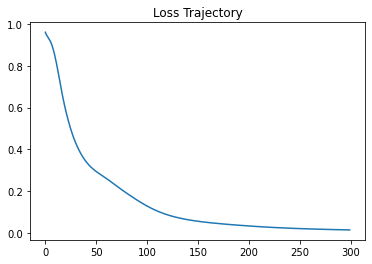

In [57]:
# plot loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss Trajectory')
plt.show()

In [58]:
# 학습 데이터 차원을 줄이고 확인한다
X_train_encoded = model_encoder.predict(X_train)
print(X_train_encoded.shape) # shape 축소되었다.
for i in range(5):
    print(X_train[i], X_train_encoded[i])
    print()

(2362, 20, 3)
[[-1.90584668 -1.83141018 -1.90711368 -1.83141018 -2.05836195 -1.75823767
   0.00271388 -0.54454236]
 [-1.85358276 -1.83426094 -1.88082335 -1.86435229 -2.06462581 -1.76773517
   0.38967395 -0.5372517 ]
 [-1.82064065 -1.72561533 -1.83552795 -1.73131685 -2.05490034 -1.77458473
   1.1058655  -0.10149927]
 [-1.73131685 -1.71864681 -1.75443968 -1.72276457 -2.03785604 -1.78127558
   1.57457442 -0.42892093]
 [-1.85896752 -1.81905689 -1.88937563 -1.81905689 -2.02140517 -1.79022177
   1.514041   -0.62360457]
 [-1.82064065 -1.75855744 -1.85611676 -1.77249449 -2.00409713 -1.79833265
   1.59319651 -0.08863674]
 [-1.77091073 -1.76964373 -1.83014318 -1.8067036  -1.97419543 -1.80659389
   1.48566798 -0.13028251]
 [-1.79023255 -1.75443968 -1.81905689 -1.78199702 -1.9451509  -1.81288379
   1.45751764  0.13797445]
 [-1.70914428 -1.68317069 -1.74493714 -1.69140622 -1.91683165 -1.81649234
   1.69369119  0.69554289]
 [-1.66669963 -1.5951139  -1.6720844  -1.63344077 -1.88877615 -1.82104479
   

In [59]:
# 결과 저장
with open(f'{data_path}/trainAE.pickle', 'wb') as f:
    pickle.dump([ndf, X_train_encoded, y_train], f, pickle.HIGHEST_PROTOCOL)

# _2_. 평균 종가 예측

feature의 개수를 autoencoder로 줄일 뿐만 아니라 학습 및 예측까지 진행한다. 결과가 어떤지 비교한다.

In [60]:
# 데이터 로드
with open(f'{data_path}/trainAE.pickle', 'rb') as f:
    df, X_train, y_train = pickle.load(f)

In [61]:
df # 원래 데이터

,open,high,low,close,maShort,maLong,macd,rsi
date,,,,,,,,
2010-05-31,-1.905847,-1.831410,-1.907114,-1.831410,-2.058362,-1.758238,0.002714,-0.544542
2010-06-01,-1.853583,-1.834261,-1.880823,-1.864352,-2.064626,-1.767735,0.389674,-0.537252
2010-06-03,-1.820641,-1.725615,-1.835528,-1.731317,-2.054900,-1.774585,1.105865,-0.101499
2010-06-04,-1.731317,-1.718647,-1.754440,-1.722765,-2.037856,-1.781276,1.574574,-0.428921
2010-06-07,-1.858968,-1.819057,-1.889376,-1.819057,-2.021405,-1.790222,1.514041,-0.623605
...,...,...,...,...,...,...,...,...
2020-01-28,1.699414,1.748510,1.584116,1.631629,1.933135,1.555955,-0.632407,0.097722
2020-01-29,1.672490,1.712084,1.615792,1.662987,1.913387,1.568251,-1.121550,-0.017689
2020-01-30,1.650634,1.672807,1.460584,1.485924,1.870431,1.576921,-1.777387,-0.252980


In [64]:
X_train.shape # 차원이 축소된 데이터

(2362, 20, 3)

In [65]:
y_train.shape

(2362, 1)

In [66]:
# 모델 파라미터 설정
n_input = int(input('입력 피쳐 수 설정: '))
n_output = int(input('출력 피쳐 수 설정: '))
n_step = int(input('recurrent timestep 설정: '))
n_hidden = int(input('은닉 노드 수 설정: '))

입력 피쳐 수 설정: 3
출력 피쳐 수 설정: 1
recurrent timestep 설정: 20
은닉 노드 수 설정: 64


In [68]:
# LSTM 모델 생성
X_input = Input(batch_shape = (None, n_step, n_input))
X_lstm = Bidirectional(LSTM(n_hidden), merge_mode='concat')(X_input)
X_lstm = Dropout(0.1)(X_lstm)
y_output = Dense(n_hidden, activation='relu')(X_lstm)
y_output = Dropout(0.1)(y_output)
y_output = Dense(n_output)(y_output)

# 모델 생성
model = Model(X_input, y_output)
print("=========== 모델 전체 구조 ===========")
print(model.summary())
print()

# 모델 학습
model.compile(loss='mse', optimizer=Adam(lr=0.001))
hist = model.fit(X_train, y_train,
                 epochs=100,
                 batch_size=300,
                 shuffle=True)

=========== 모델 전체 구조 ===========
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 3)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               34816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 43,137
Trainable params: 43,137
Non-trainable params: 0
______________________

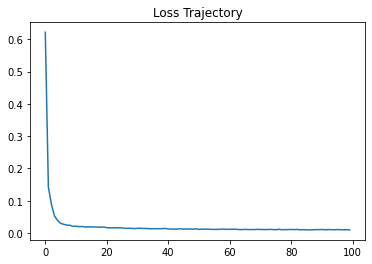

In [69]:
# plot loss
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss Trajectory')
plt.show()

In [70]:
# 5일 후 주가 이동평균 값 예측
X_pred = np.reshape(X_train[-1], (-1, n_step, n_input))
X_pred

array([[[ 0.5319474 ,  0.42260456,  0.17807007],
        [ 0.5165871 ,  0.35768583,  0.26544008],
        [ 0.5647369 ,  0.38819212,  0.2997633 ],
        [ 0.59462845,  0.3146367 ,  0.30541718],
        [ 0.71760637,  0.18714648,  0.31670865],
        [ 0.700021  ,  0.13324367,  0.284945  ],
        [ 0.8155086 , -0.03858918,  0.28203326],
        [ 0.8745609 , -0.06652907,  0.29202634],
        [ 0.91825974, -0.15028992,  0.2891301 ],
        [ 0.950987  , -0.1373002 ,  0.30504653],
        [ 0.9192803 , -0.05527693,  0.33557466],
        [ 0.8884702 ,  0.02417354,  0.38019258],
        [ 0.8985504 ,  0.07654196,  0.42524275],
        [ 0.92096406,  0.00542146,  0.45744905],
        [ 0.83078027,  0.09503077,  0.4435199 ],
        [ 0.89004135,  0.11709179,  0.43150514],
        [ 0.93591154,  0.11677253,  0.46433017],
        [ 1.0074693 ,  0.01767957,  0.4603017 ],
        [ 0.88234675,  0.12486199,  0.40010095],
        [ 0.997353  ,  0.14038427,  0.34889522]]], dtype=float32)

In [72]:
y_pred = model.predict(X_pred)[0][0]
y_pred

1.9249876

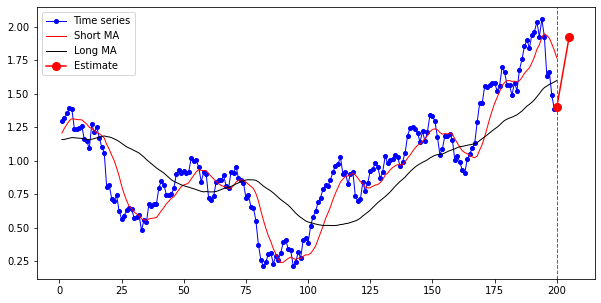

In [76]:
# 마지막 100개 데이터 plot 후 다음 값 그려 보기
last_data = np.array(df.iloc[-200:, [3, 4, 5]]) # 종가, 단기이평, 장기이평

# 원 시계열과 예측된 시계열을 그린다
ax1 = np.arange(1, len(last_data) + 1)
ax2 = np.arange(len(last_data), len(last_data) + 5 + 1)
plt.figure(figsize=(10, 5))
plt.plot(ax1, last_data[:, 0], 'b-o', markersize=4, color='blue', label='Time series', linewidth=1)
plt.plot(ax1, last_data[:, 1], color='red', label='Short MA', linewidth=1)
plt.plot(ax1, last_data[:, 2], color='black', label='Long MA', linewidth=1)
plt.plot((200, 205), (last_data[-1:, 0], y_pred), 'b-o', markersize=8, color='red', label='Estimate')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()